# P7 - Convolutional Neural Networks (CNNs)
We have now learned about the Perceptron, Linear and logistic regression, Multi-layer perceptron and backpropagation, Auto-encoders.

In this pratical session about Convolutional Neural Networks (CNNs) we will use the MNIST datasets.

First, we will obtain baselines using a Logistic Regression and a Feed-forward Neural Network.

## 0.0 - Imports
We will need to import some libraries to be used in this session. Libraries include data visualizers ([matplotlib](https://matplotlib.org/)), neural network package ([torch](https://pytorch.org/)), and other helper packages for data handling ([sklearn](https://scikit-learn.org/), [numpy](https://numpy.org/)).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import copy

Then, other variable definitions are needed to be set. This includes the size of the dataset we will use, and the configuration of the GPU to be activated:

In [2]:
# Configure Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### 0.1 - Create Dataloaders
#### MNIST dataset
Using torchvision we can easily download and use the MNIST dataset to create our train and validation dataloaders

In [3]:
# Define tranform - Convert data to tensor and normalize using dataset mean and std
# mean and std are computed offline using the training dataset
# tranforms.Normalize expects a value of mean and std per image channel
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# Download and create MNIST train and validation dataloaders
mnist_train_dataset = datasets.MNIST('../data', download=True, train=True, transform=mnist_transform)
mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform)
mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_val_dataloader = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)

# MNIST Dataloaders to get data into numpy for Logistic Regression
mnist_train_dataloader_numpy = DataLoader(mnist_train_dataset, batch_size=len(mnist_train_dataset))
mnist_val_dataloader_numpy = DataLoader(mnist_val_dataset, batch_size=len(mnist_val_dataset))
X_y_train = next(iter(mnist_train_dataloader_numpy))
X_y_val = next(iter(mnist_val_dataloader_numpy))
X_train = X_y_train[0].numpy()
y_train = X_y_train[1].numpy()
X_val = X_y_val[0].numpy()
y_val = X_y_val[1].numpy()

dataloaders = dict(train=mnist_train_dataloader, val=mnist_val_dataloader)


We can check the MNIST dataset properties such as:

- shape of train and validation datasets - \[number of samples, width, height\]
- number of input feature on the flattened/reshaped input for Logistic Regression or MLP
- shape of train and validation batches - \[batch size, number of channels, width, height\]

In [4]:
# get batch to extract properties and plot example images
# next(enumerator(dataloader)) -> creates an iterator of the dataloader and gets the next batchß
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_train_dataloader))
# info about the dataset
D_in = np.prod(example_imgs.shape[1:])
D_out = len(mnist_train_dataloader.dataset.targets.unique())
print("Datasets shapes:", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", D_in, "Output classes:", D_out)
print("Train batch:", example_imgs.shape, example_targets.shape)
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_val_dataloader))
print("Val batch:", example_imgs.shape, example_targets.shape)

Datasets shapes: {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


We can plot some examples with corresponding labels using the following function. This function can also receive the predicted labels.

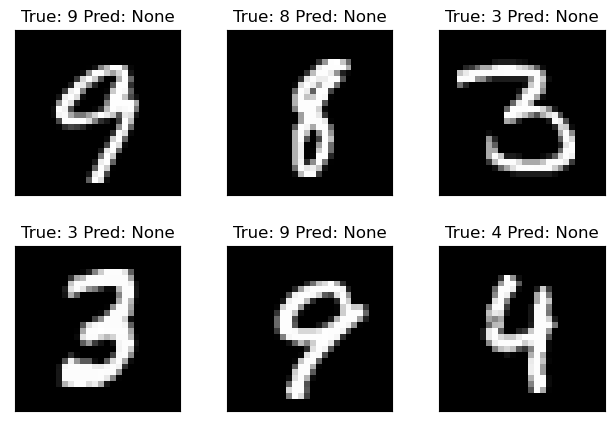

In [5]:
def plot_img_label_prediction(imgs, y_true, y_pred=None, shape=(2, 3)):
    y_pred = [None] * len(y_true) if y_pred is None else y_pred
    fig = plt.figure()
    for i in range(np.prod(shape)):
        plt.subplot(*shape, i+1)
        plt.tight_layout()
        plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
        plt.title("True: {} Pred: {}".format(y_true[i], y_pred[i]))
        plt.xticks([])
        plt.yticks([])

plot_img_label_prediction(imgs=example_imgs, y_true=example_targets, y_pred=None, shape=(2, 3))


## Question 3.1.1
### Logistic Regression

We can use a very simple Logistic Regression that receives our input images as a vector and predicts the digit. This will be our first baseline to compare with the CNNs.

In [6]:
# Use standard scaler to transform input data
scaler = StandardScaler()
X_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1)))

# Use scikit-learn Logistic Regression with C=50., multi_class='multinomial', solver='sag', tol=0.1
clf = LogisticRegression(C=50., multi_class='multinomial', solver='sag', tol=0.1)
clf.fit(X_train, y_train)
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

Test score with penalty: 0.9033


We can select the coefficients for each class and reshape them into the image shape to plot them. This allows us to visualize what are the pixels that are contributing more to the classification for each of the digits.

But what happens if the digits are not centered? Will we still get such a good performance? Lets test that out later!

## Question 3.1.2
### Feed-Forward Neural Network

The first step is to create the functions that will allow us to implement a feed-forward neural network and manage the training and validation process.

The MLP class will define the architecture of a feed-forward neural network, with a set of hidden layers (fully connected layers [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)), with a activation function in between them ([relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu)), and a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) in the last layer. Since the dataset poses a multiclass classification problem, the last layer should have a number of neurons equal to the number of classes.

In [9]:
class MLP(nn.Module):
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        # define layers
        self.dim_layers = dim_layers
        layer_list = [nn.Linear(dim_layers[l], dim_layers[l+1]) for l in range(len(dim_layers) - 1)]
        self.lin_layers = nn.ModuleList(layer_list)

    def forward(self, X):
        # reshape X
        X = X.view(-1, self.dim_layers[0])
        # apply relu
        for layer in self.lin_layers[:-1]:
            X = F.relu(layer(X))
        # use softmax for output layer
        return F.log_softmax(self.lin_layers[-1](X), dim=1)

##### training validation function for the MLP and CNN

In [10]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # init dictionaries to save losses and accuracies of training and validation
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # execute a training and validation phase for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to train mode
            else:
                model.eval()   # Set model to eval mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # set the parameter gradients to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # if in training phase, perform backward prop and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # increment loss and correct counts
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights to return
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

We will start by creating a simple network with some hidden layers. Thus, in addition to the input, it will have 3 fully connected layer which, in this implemetation, is assigned to the input of the MLP Class. We will use the Stochastic Gradient Descend optimizer ([optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) with 0.01 learning rate and 0.5 momentum. The loss function to be optimized will be negative log likelihood ([nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). Training and validation will be managed by the function "train_val_model" previously define.

Epoch 0/14
----------
train Loss: 0.7626 Acc: 78.12%
val Loss: 0.2968 Acc: 91.38%

Epoch 2/14
----------
train Loss: 0.1753 Acc: 94.88%
val Loss: 0.1478 Acc: 95.61%

Epoch 4/14
----------
train Loss: 0.1092 Acc: 96.86%
val Loss: 0.1052 Acc: 96.70%

Epoch 6/14
----------
train Loss: 0.0754 Acc: 97.75%
val Loss: 0.0920 Acc: 97.23%

Epoch 8/14
----------
train Loss: 0.0549 Acc: 98.42%
val Loss: 0.0784 Acc: 97.58%

Epoch 10/14
----------
train Loss: 0.0408 Acc: 98.83%
val Loss: 0.0752 Acc: 97.49%

Epoch 12/14
----------
train Loss: 0.0302 Acc: 99.21%
val Loss: 0.0748 Acc: 97.76%

Epoch 14/14
----------
train Loss: 0.0220 Acc: 99.45%
val Loss: 0.0710 Acc: 98.04%

Training complete in 4m 10s
Best val Acc: 98.04%


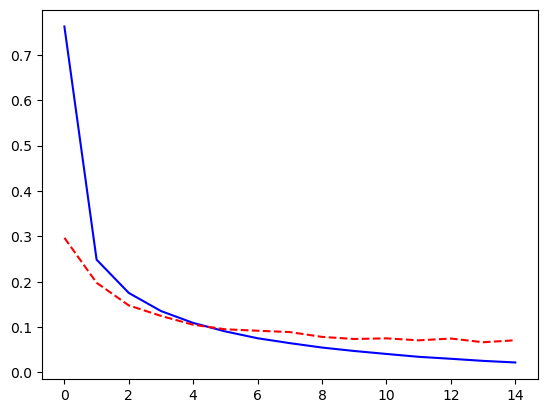

In [11]:
# instantiate model
model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device)

# instantiate optimizer and criterion
optimizer = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

# train and validate model
model_mlp, losses, accuracies = train_val_model(model_mlp, criterion, optimizer, dataloaders,
                       num_epochs=15, log_interval=2)

# plot losses
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

## Question 3.1.3
### Plots of the coefficients of the Logistic Regression for each class

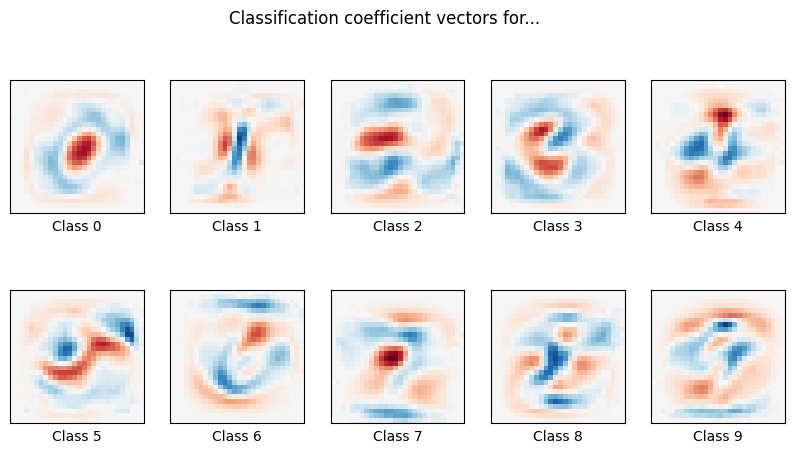

In [19]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    # iterate over the classes and reshape coefficients to ensure proper visualization
    l1_plot.imshow(<COMPLETE_HERE>, interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()

## Question 3.2
### Convolutional Neural Network

Convolutional layers capture patterns corresponding to relevant features independently of where they occur in the input. To do so, they slide a window over the input and apply the convolution operation with a set of kernels or filters that represent the features. Although it is not their only field of application, convolutional neural networks are mainly praised for their performance on image processing tasks.

The training and validation management for the CNN implementation will be performed as the feed-forward network, however we will have to define the network's architecture.

For that we will implement a CNN class to define how many layers it comprises and how the layers will be connected.

The initialization (`__init__`) function will define the architecture and the `forward` function will implement how the different layers are connected. This architecture will be a sequece of 2 convolutional layers ([nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) (1st: output channels 10, kernel size 5; 2nd: output channels 20, kernel size 5), then 2 fully connected layers ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) (1st: output features 50; 2nd: output features 10 (the number of classes)). Once again, the final layer will be a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) function  that will choose the most probable class of the 10 in the input.

Between the second convolution layer and the first fully connected, we will set a dropout layer ([nn.Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)). The idea behind dropout is to disable a percentage of randomly selected neurons during each step of the training phase, in order to avoid overfitting.

In [12]:
class CNN(nn.Module):
    """Basic Pytorch CNN for MNIST-like data."""

    def __init__(self):
        super(CNN, self).__init__()
        # define convolution and linear layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, T=1.0):
        # Batch size = 64, images 28x28 =>
        #     x.shape = [64, 1, 28, 28]
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv1(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        # Convolution with 5x5 filter without padding and 10 channels =>
        #     x.shape = [64, 10, 24, 24] since 24 = 28 - 5 + 1
        # Max pooling with stride of 2 =>
        #     x.shape = [64, 10, 12, 12]
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.conv2_drop(x)
        x = self.conv2(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        # Convolution with 5x5 filter without padding and 20 channels =>
        #     x.shape = [64, 20, 8, 8] since 8 = 12 - 5 + 1
        # Max pooling with stride of 2 =>
        #     x.shape = [64, 20, 4, 4]
        x = x.view(-1, 320)
        # Reshape =>
        #     x.shape = [64, 320]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

As previously, lets describe the model to be trained. We will use the ADAM optimizes ([optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)), with learning rate 0.001, and the same negative log likelihood ([nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)).

Epoch 0/24
----------
train Loss: 0.6077 Acc: 79.99%
val Loss: 0.1096 Acc: 96.49%

Epoch 2/24
----------
train Loss: 0.2014 Acc: 93.84%
val Loss: 0.0539 Acc: 98.26%

Epoch 4/24
----------
train Loss: 0.1557 Acc: 95.19%
val Loss: 0.0425 Acc: 98.57%

Epoch 6/24
----------
train Loss: 0.1377 Acc: 95.94%
val Loss: 0.0380 Acc: 98.64%

Epoch 8/24
----------
train Loss: 0.1201 Acc: 96.30%
val Loss: 0.0339 Acc: 98.84%

Epoch 10/24
----------
train Loss: 0.1164 Acc: 96.53%
val Loss: 0.0309 Acc: 98.89%

Epoch 12/24
----------
train Loss: 0.1099 Acc: 96.64%
val Loss: 0.0322 Acc: 98.97%

Epoch 14/24
----------
train Loss: 0.1034 Acc: 96.90%
val Loss: 0.0323 Acc: 98.92%

Epoch 16/24
----------
train Loss: 0.1007 Acc: 97.03%
val Loss: 0.0292 Acc: 99.03%

Epoch 18/24
----------
train Loss: 0.0975 Acc: 97.11%
val Loss: 0.0314 Acc: 98.93%

Epoch 20/24
----------
train Loss: 0.0939 Acc: 97.14%
val Loss: 0.0291 Acc: 99.09%

Epoch 22/24
----------
train Loss: 0.0910 Acc: 97.30%
val Loss: 0.0301 Acc: 99.10

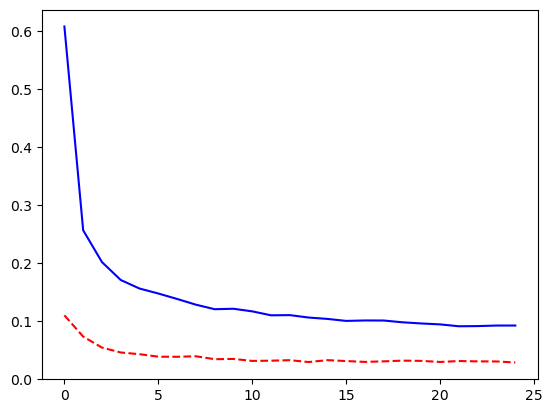

In [13]:
# instatiate the model, optimizer and criterion
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# train and validate model
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=25, log_interval=2)

# plot the losses
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

We have now completed training and validation with 3 different models: Logistic Regression, Feed-Forward Network, and Convolutional Neural Network.

We have seen that with the CNN, the performance of the model in the validation set, outperforms the other models (~99% accuracy against ~90% and ~98%).

## Question 3.3
### Number of learnable parameters of the MLP and the CNN

The difference in performance between CNNs and MLP is small but how many learnable parameters are we using in the MLP and in CNN models?

We can find it out using the following lines of code:

In [15]:
# get MLP trainable model parameters
model_parameters_mlp = filter(lambda p: p.requires_grad, model_mlp.parameters())
params_mlp = sum([np.prod(p.size()) for p in model_parameters_mlp])
print('Number of parameters in the MLP model: {}'.format(params_mlp))

# get CNN trainable model parameters
model_parameters_cnn = filter(lambda p: p.requires_grad, model.parameters())
params_cnn = sum([np.prod(p.size()) for p in model_parameters_cnn])
print('Number of parameters in the CNN model: {}'.format(params_cnn))

Number of parameters in the MLP model: 242762
Number of parameters in the CNN model: 21840


You can see that we have ~11x more learnable parameters to achieve almost the same performance.

We can experiment and try to find out the number of layers and corresponding sizes.

## Question 3.4
### Change number of MLP hidden layers to approximate the number of learnable parameters of the CNN. What is the impact on the performance?

In [16]:
# instantiate smaller MLP
model_mlp_test = MLP([D_in, 32, D_out]).to(device)
model_parameters_mlp_test = filter(lambda p: p.requires_grad, model_mlp_test.parameters())
params_mlp_test = sum([np.prod(p.size()) for p in model_parameters_mlp_test])
print('Number of parameters in the MLP model: {}'.format(params_mlp_test))

Number of parameters in the MLP model: 25450


And how does that model perform? We are about to find out

Epoch 0/14
----------
train Loss: 0.4654 Acc: 87.36%
val Loss: 0.2765 Acc: 92.24%

Epoch 5/14
----------
train Loss: 0.1496 Acc: 95.76%
val Loss: 0.1511 Acc: 95.57%

Epoch 10/14
----------
train Loss: 0.1052 Acc: 96.97%
val Loss: 0.1203 Acc: 96.21%

Training complete in 3m 35s
Best val Acc: 96.60%


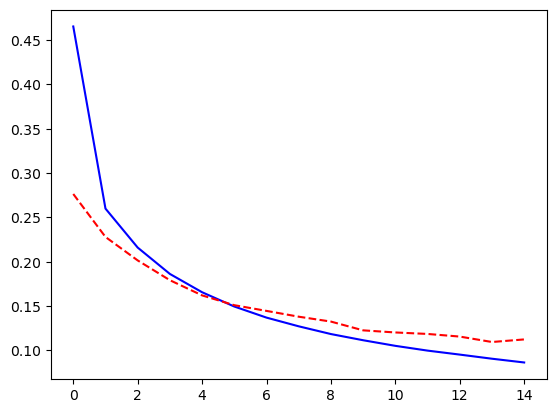

In [17]:
#instantiate optimizer and criterion
optimizer = optim.SGD(model_mlp_test.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

# train model
model_mlp_test, losses, accuracies = train_val_model(model_mlp_test, criterion,
                                                     optimizer, dataloaders,
                                                     num_epochs=15,
                                                     log_interval=5)

#plot losses
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

We can see a drop in performance compared with the previous MLP model. So we can understand that although we have less learnable parameters, due to properties of CNNs (e.g., invariance and parameter sharing), which allow them to have fewer weights as some parameters are shared.

## Question 3.5
### What happens in each of the classifiers if for some reason your validation set does not always have the digits centered in your input image?

CNNs are expected to be invariant to the location where important features occur in the input. In fact, it's not unusual that there is a dataset shift where the data acquisition process suffers some modification. We will do this by applying a transformation with horizontal translations to our validation dataset and see how robust each model is to these shifts.

We can do this by going back to **0.1 - Create Dataloaders -
MNIST dataset** cell to define the test transform using the following code

```
mnist_transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(0, translate=[0.1, 0]),
     transforms.Normalize((0.1307,), (0.3081,))])
```

and replace

`mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform)`

with

`mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform_val)`

In [18]:
# These random translations will be added in the end of this notebook, for now we skip this.
mnist_transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(0, translate=[0.1, 0]),
     transforms.Normalize((0.1307,), (0.3081,))])

# Create MNIST validation dataloaders using transform validation with translation
mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform_val)
mnist_val_dataloader = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)

# MNIST Dataloader for to get data into numpy for Logistic Regression
mnist_val_dataloader_numpy = DataLoader(mnist_val_dataset, batch_size=len(mnist_val_dataset))
X_y_val = next(iter(mnist_val_dataloader_numpy))
X_val = X_y_val[0].numpy()
y_val = X_y_val[1].numpy()

dataloaders = dict(train=mnist_train_dataloader, val=mnist_val_dataloader)

#### Logistic Regression

In [19]:
# score the model on the validation dataset after translation
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1)))
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

Test score with penalty: 0.7184


#### MLP

Epoch 0/14
----------
train Loss: 0.8023 Acc: 78.54%
val Loss: 0.9275 Acc: 74.67%

Epoch 2/14
----------
train Loss: 0.1821 Acc: 94.66%
val Loss: 0.8027 Acc: 78.57%

Epoch 4/14
----------
train Loss: 0.1101 Acc: 96.78%
val Loss: 0.6883 Acc: 81.65%

Epoch 6/14
----------
train Loss: 0.0747 Acc: 97.81%
val Loss: 0.6328 Acc: 83.19%

Epoch 8/14
----------
train Loss: 0.0539 Acc: 98.38%
val Loss: 0.5585 Acc: 85.11%

Epoch 10/14
----------
train Loss: 0.0399 Acc: 98.84%
val Loss: 0.5461 Acc: 85.95%

Epoch 12/14
----------
train Loss: 0.0289 Acc: 99.22%
val Loss: 0.5533 Acc: 86.31%

Epoch 14/14
----------
train Loss: 0.0210 Acc: 99.46%
val Loss: 0.5446 Acc: 87.22%

Training complete in 5m 46s
Best val Acc: 87.37%


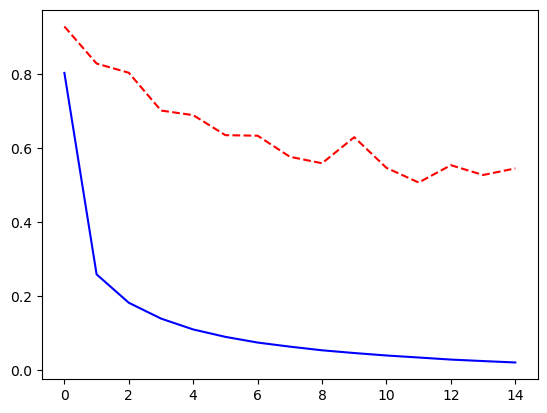

In [20]:
#instantiate the model
model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device)

#instantiate optimizer and criterion
optimizer = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

#train model and obtain loss and accuracy for translated validation dataset
model_mlp, losses, accuracies = train_val_model(model_mlp, criterion, optimizer, dataloaders,
                       num_epochs=15, log_interval=2)

# plot losses
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

#### CNN

Epoch 0/24
----------


train Loss: 0.6168 Acc: 79.73%
val Loss: 0.2417 Acc: 92.43%

Epoch 2/24
----------
train Loss: 0.1960 Acc: 94.11%
val Loss: 0.1250 Acc: 96.02%

Epoch 4/24
----------
train Loss: 0.1544 Acc: 95.34%
val Loss: 0.0927 Acc: 97.34%

Epoch 6/24
----------
train Loss: 0.1261 Acc: 96.20%
val Loss: 0.1031 Acc: 97.18%

Epoch 8/24
----------
train Loss: 0.1192 Acc: 96.39%
val Loss: 0.0923 Acc: 97.13%

Epoch 10/24
----------
train Loss: 0.1099 Acc: 96.70%
val Loss: 0.0861 Acc: 97.47%

Epoch 12/24
----------
train Loss: 0.1047 Acc: 96.95%
val Loss: 0.0817 Acc: 97.60%

Epoch 14/24
----------
train Loss: 0.0971 Acc: 97.03%
val Loss: 0.0707 Acc: 97.88%

Epoch 16/24
----------
train Loss: 0.0951 Acc: 97.08%
val Loss: 0.0826 Acc: 97.83%

Epoch 18/24
----------
train Loss: 0.0950 Acc: 97.09%
val Loss: 0.0731 Acc: 97.59%

Epoch 20/24
----------
train Loss: 0.0889 Acc: 97.31%
val Loss: 0.0791 Acc: 97.77%

Epoch 22/24
----------
train Loss: 0.0871 Acc: 97.38%
val Loss: 0.0735 Acc: 97.88%

Epoch 24/24
-------

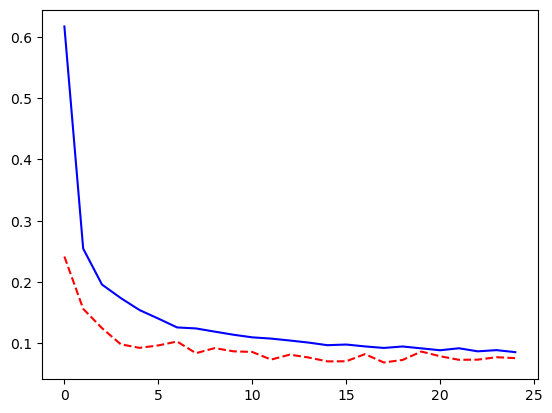

In [21]:
# instantiate model, optimizer and criterion
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# train model and obtain loss and accuracy for the translated validation dataset
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=25, log_interval=2)

# plot losses
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

After rerunning the different models we can see that the accuracy of the Logistic Regression drops from ~90% to ~72%, the MLP drops from ~98% to ~87%, and the CNN drops from ~99% to ~97%. This shows that the learned features are more robust to variances in location, as expected.

# Bonus Case - Attention with small images and CNNs.  (And how to create a dataset that takes numpy arrays)

In this case we will use the Scikit-Learn's digits dataset

## Scikit-Learn Digits

This dataset is provided by scikit-learn and the digit images are returned as numpy ndarray. We will use PIL (Python Image Library) to convert the numpy ndarray to a image, tranform it to a tensor and normalize it.

In this case we don't have a predefined Digits Dataset provided by torchvision so we will need to write a custom Dataset class and implement three functions:

`__init__`, `__len__`, and `__getitem__`.

Scikit-Learn return the digits images and labels as ndarrays. Each digit image is an 8x8 array.

To use the previous CNN, we will use a transform to resize the images to the MNIST image size.

In [23]:
SKLEARN_DIGITS_TRAIN_SIZE = 1247
SKLEARN_DIGITS_VAL_SIZE = 550

class NumpyDataset(Dataset):

  def __init__(self, data, targets, transform=None):
    self.data = torch.from_numpy(data).float()
    self.targets = torch.from_numpy(targets).long()
    self.transform = transform

  def __getitem__(self, index):
    x = np.expand_dims(self.data[index], axis=2)
    y = self.targets[index]
    if self.transform:
        x = self.transform(x)
    return x, y

  def __len__(self):
    return len(self.data)

digits_transform = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.Resize(28),
                                       transforms.ToTensor(),
                                       ])

# Get sklearn digits dataset
X, y = load_digits(return_X_y=True)
X = X.reshape((len(X), 8, 8))
y_train = y[:-SKLEARN_DIGITS_VAL_SIZE]
y_val = y[-SKLEARN_DIGITS_VAL_SIZE:]
X_train = X[:-SKLEARN_DIGITS_VAL_SIZE]
X_val = X[-SKLEARN_DIGITS_VAL_SIZE:]

digits_train_dataset = NumpyDataset(X_train, y_train, transform=digits_transform)
digits_val_dataset = NumpyDataset(X_val, y_val, transform=digits_transform)
digits_train_dataloader = torch.utils.data.DataLoader(digits_train_dataset, batch_size=64, shuffle=True)
digits_val_dataloader = torch.utils.data.DataLoader(digits_val_dataset, batch_size=64, shuffle=True)

dataloaders = dict(train=digits_train_dataloader, val=digits_val_dataloader)

In [24]:
# Get some examples of images and targets
_, (example_train_imgs, example_train_targets) = next(enumerate(digits_train_dataloader))
_, (example_val_imgs, example_val_targets) = next(enumerate(digits_val_dataloader))

# Info about the dataset
D_in = np.prod(example_imgs.shape[1:])
D_out = len(digits_train_dataloader.dataset.targets.unique())

# Output information
print("Datasets shapes (before transformations):", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", D_in, "Output classes:", D_out)
print("Train batch:", example_train_imgs.shape, example_train_targets.shape)
print("Val batch:", example_val_imgs.shape, example_val_targets.shape)

Datasets shapes (before transformations): {'train': torch.Size([1247, 8, 8]), 'val': torch.Size([550, 8, 8])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


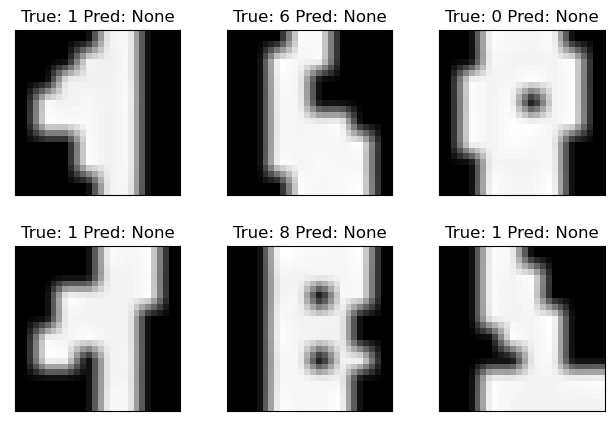

In [25]:
plot_img_label_prediction(imgs=example_train_imgs, y_true=example_train_targets, y_pred=None, shape=(2, 3))


### Logistic Regression

In [ ]:
scaler = StandardScaler()
print(X_train.squeeze().shape)
X_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1)))

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50., multi_class='multinomial', solver='sag', tol=0.1)
clf.fit(X_train, y_train)
#sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

(1247, 64)
Test score with penalty: 0.8873


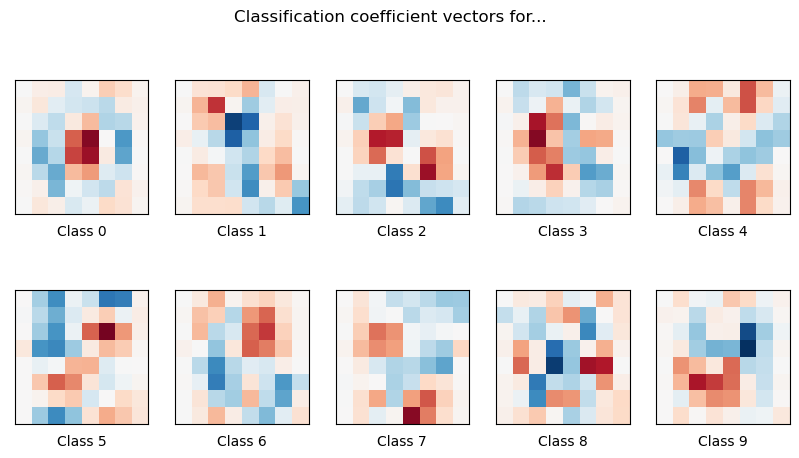

In [28]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(8, 8), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()

### Feed-forward using digits dataset

Epoch 0/19
----------
train Loss: 2.3054 Acc: 10.10%
val Loss: 2.3030 Acc: 10.18%

Epoch 2/19
----------
train Loss: 2.3002 Acc: 10.43%
val Loss: 2.2981 Acc: 11.45%

Epoch 4/19
----------
train Loss: 2.2945 Acc: 16.76%
val Loss: 2.2923 Acc: 19.09%

Epoch 6/19
----------
train Loss: 2.2875 Acc: 19.17%
val Loss: 2.2854 Acc: 20.55%

Epoch 8/19
----------
train Loss: 2.2787 Acc: 25.58%
val Loss: 2.2765 Acc: 26.55%

Epoch 10/19
----------
train Loss: 2.2675 Acc: 37.29%
val Loss: 2.2651 Acc: 36.36%

Epoch 12/19
----------
train Loss: 2.2520 Acc: 46.27%
val Loss: 2.2487 Acc: 44.55%

Epoch 14/19
----------
train Loss: 2.2285 Acc: 52.61%
val Loss: 2.2231 Acc: 53.27%

Epoch 16/19
----------
train Loss: 2.1896 Acc: 53.73%
val Loss: 2.1800 Acc: 54.36%

Epoch 18/19
----------
train Loss: 2.1197 Acc: 55.01%
val Loss: 2.1017 Acc: 50.91%

Training complete in 0m 8s
Best val Acc: 54.36%


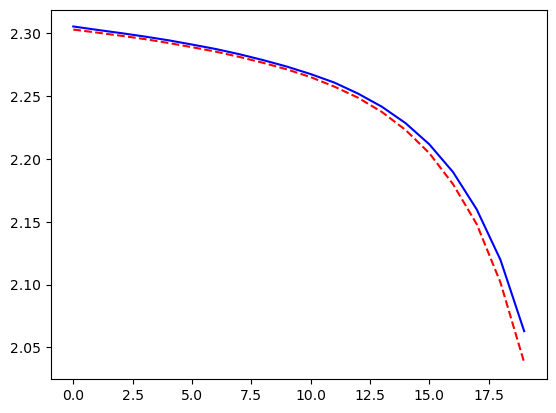

In [29]:
model = MLP([D_in, 512, 256, 128, 64, D_out]).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=20, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

Epoch 0/49
----------
train Loss: 2.2846 Acc: 13.71%
val Loss: 2.2592 Acc: 32.00%

Epoch 10/49
----------
train Loss: 0.7383 Acc: 74.90%
val Loss: 0.5641 Acc: 84.18%

Epoch 20/49
----------
train Loss: 0.5266 Acc: 82.44%
val Loss: 0.4419 Acc: 87.09%

Epoch 30/49
----------
train Loss: 0.4694 Acc: 84.20%
val Loss: 0.4321 Acc: 86.18%

Epoch 40/49
----------
train Loss: 0.3917 Acc: 86.05%
val Loss: 0.3873 Acc: 88.00%

Training complete in 0m 35s
Best val Acc: 88.36%


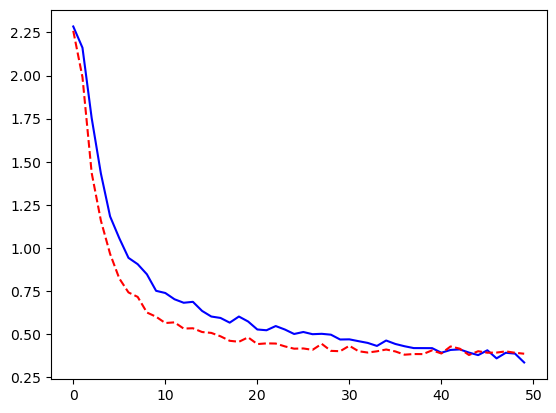

In [30]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=50, log_interval=10)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

# Bonus Information - Visualizing CNN filters

Some work have been done to demonstrate the type of features learned by different filters in different layers.

For instance, considering a known CNN called **VGG16** which has the following architecture

![image](https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16.jpg)\[taken from: https://www.geeksforgeeks.org/vgg-16-cnn-model/ \]

these would be some of the filters from some of the layers:
<table border=0 width="500px" >
	<tbody>
		<tr>
			<td width="19%" align="center"> Layer 2 <br /> (Conv 1-2)</td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l2_f1.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l2_f21.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l2_f54.jpg"> </td>
		</tr>
		<tr>
			<td width="19%" align="center"> Layer 10 <br /> (Conv 2-1)</td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l10_f7.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l10_f10.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l10_f69.jpg"> </td>
		</tr>
		<tr>
			<td width="19%" align="center"> Layer 17 <br /> (Conv 3-1)</td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l17_f4.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l17_f8.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l17_f9.jpg"> </td>
		</tr>
		<tr>
			<td width="19%" align="center"> Layer 24 <br /> (Conv 4-1)</td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l24_f4.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l24_f17.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l24_f22.jpg"> </td>
		</tr>
	</tbody>
</table>

or obtain the class activations:
<table border=0 width="500px" >
	<tbody>
    <tr>		<td width="27%" align="center"> Input Image </td>
			<td width="27%" align="center"> Layer Vis. (Filter=0)</td>
			<td width="27%" align="center"> Filter Vis. (Layer=29)</td>
		</tr>
<tr>
			<td width="27%"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png"> </td>
			<td width="27%"> <img src="https://raw.githubusercontent.com/utkuozbulak/cnn-gifs/master/spider_layer_graph.gif"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/cnn-gifs/master/spider_filter_graph.gif"> </td>
		</tr>
	</tbody>
</table>

\[examples taken from: http://www.github.com/utkuozbulak/pytorch-cnn-visualizations \]


# Bonus Information - Predefined architectures, pre-trained models and transfer learning

Packages like [torchvision](https://pytorch.org/vision/stable/index.html) and [timm](https://rwightman.github.io/pytorch-image-models/) offer you the possibility of using predefined architectures or even use pre-trained models that can be used to fine tune the models for that same task or used for transfer learning.

Besides datasets, transforms and others, **Torchvision** has a large number of predefined architecture with the possibility of loading the pre-trained weights.

#### Torchvision classification models examples



In [32]:
import torchvision.models as models

# construct a model with random weights to be trained
resnet18 = models.resnet18()

# load a pre-trained model
resnet18 = models.resnet18(pretrained=True)

For examples of different models and how to use pre-trained weights please visit https://pytorch.org/vision/stable/models.html#



Another possibility is **timm** which contains models for classification only.
In **timm** you are not restricted to have inputs only with 1/3-channels, allowing you to use architectures or pre-trained models using images that have 2 or > 3-channels.

#### timm classification models examples

In [34]:
if 'google.colab' in str(get_ipython()):
  !pip install -q timm
import timm

# list all models
print(timm.list_models())

# list pre-trained models
print(timm.list_models(pretrained=True))

# list models architectures by wildcards
print(timm.list_models('*resne*t*'))

# construct a model with random weights to be trained
model = timm.create_model('resnet18')

# load a pre-trained model
model = timm.create_model('resnet18', pretrained=True)

['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

For more details on how to use this package visit https://rwightman.github.io/pytorch-image-models/